In [110]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from Utilities import orbits as orb
from Utilities import sections as sec 

from Utilities.operators import make_tree
from Utilities.time_extractor import days_since_distruption
matplotlib.rcParams['figure.dpi'] = 150

In [111]:
G = 1
m = 4
Mbh = 10**m
beta = 1
mstar = .5
Rstar = .47
n = 1.5
check = 'Compton' # 'Compton' or 'ComptonHiRes' or 'ComptonRes20'
folder = f'R{Rstar}M{mstar}BH{Mbh}beta{beta}S60n{n}'
snap = '115'
path = f'TDE/{folder}{check}/{snap}'
saving_path = f'Figs/{folder}/{check}'
print(f'We are in: {path}, \nWe save in: {saving_path}')
is_tde = True

Rt = Rstar * (Mbh/mstar)**(1/3)
Rp =  Rt / beta
R0 = 0.6 * Rp
apo = 2 * Rt * (Mbh/mstar)**(1/3)
normalization = Mbh/Rt * (Mbh/Rstar)**(-1/3)#30.7

G_SI = 6.6743e-11
Msol = 2e30 #1.98847e30 # kg
Rsol = 7e8 #6.957e8 # m
t = np.sqrt(Rsol**3 / (Msol*G_SI ))

c = 3e8 / (7e8/t)
M_bh = 10**m
Rs = 2*G*Mbh / c**2



We are in: TDE/R0.47M0.5BH10000beta1S60n1.5Compton/115, 
We save in: Figs/R0.47M0.5BH10000beta1S60n1.5/Compton


In [112]:
data = make_tree(path, snap, is_tde, energy = False)

dim_cell = data.Vol**(1/3) # according to Elad
tfb = days_since_distruption(f'{path}/snap_{snap}.h5', m, mstar, Rstar, choose = 'tfb')

days after disruption: 0.5283548899394039 // t_fall: 2.5777261297507925 // sim_time: 28.659516017187894


In [113]:
midplane = np.abs(data.Z) < dim_cell
X_midplane, Y_midplane, VX_midplane, VY_midplane, Mass_midplane, Den_midplane = \
    sec.make_slices([data.X, data.Y, data.VX, data.VY, data.Mass, data.Den], midplane)

In [114]:
section = np.logical_and(X_midplane < -5*Rt, Y_midplane>0)
X_section, Y_section, VX_section, VY_section, Mass_section, Den_section = \
    sec.make_slices([X_midplane, Y_midplane, VX_midplane, VY_midplane, Mass_midplane, Den_midplane], section)

In [115]:
R_cyl = np.sqrt(X_midplane**2 + Y_midplane**2)
V_cyl = np.sqrt(VX_midplane**2 + VY_midplane**2)
orbital_enegy = orb.orbital_energy(R_cyl, V_cyl, G, M_bh)

In [116]:
R_cyl_sec = np.sqrt(X_section**2 + Y_section**2)
V_cyl_sec = np.sqrt(VX_section**2 + VY_section**2)
orbital_enegy_sec = orb.orbital_energy(R_cyl_sec, V_cyl_sec, G, M_bh)

In [117]:
idx_Rt = np.argmin(np.abs(R_cyl - Rt))
deltaE_abs = np.abs(0.5*V_cyl[idx_Rt]**2 - G*Mbh/R_cyl[idx_Rt])
bins = np.linspace(-deltaE_abs, deltaE_abs, 250)

# OE_mid = orbital_enegy / normalization
# bins = np.arange(-4, 4, .01)

In [118]:
# obtain an histogram of the energy distribution
hist, bins = np.histogram(orbital_enegy, bins = bins)
mass_sum = np.zeros(len(bins)-1)
mass_sum_sec = np.zeros(len(bins)-1)
# obtain the mass of each bin using all the cells in the midplane
for i in range(len(bins)-1):
    idx = np.where((orbital_enegy > bins[i]) & (orbital_enegy < bins[i+1]))
    mass_sum[i] = np.sum(Mass_midplane[idx])
    idx2 = np.where((orbital_enegy_sec > bins[i]) & (orbital_enegy_sec < bins[i+1]))
    mass_sum_sec[i] = np.sum(Mass_section[idx2])
dm_dE = mass_sum / np.diff(bins)
bins /= normalization

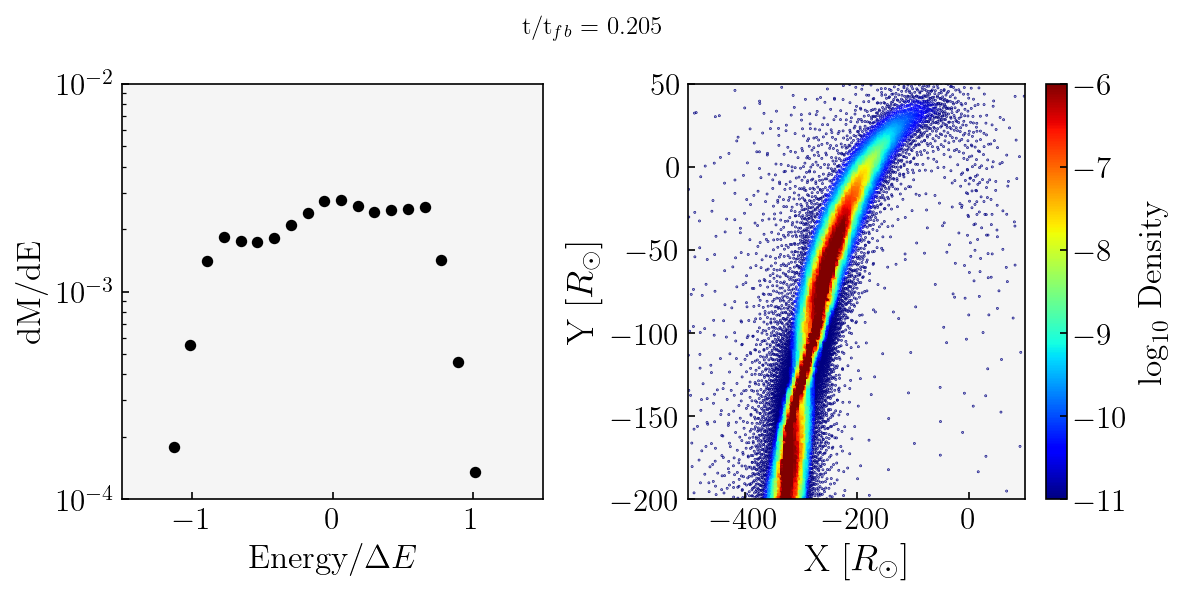

In [119]:
# plot the mass distribution with respect to the energy
fig, ax = plt.subplots(1,2, figsize = (8,4))
img = ax[1].scatter(X_midplane, Y_midplane, c = np.log10(Den_midplane), s = .1, cmap = 'jet', vmin = -11, vmax = -6)
cbar = plt.colorbar(img)
cbar.set_label(r'$\log_{10}$ Density', fontsize = 16)
ax[1].set_xlim(-500,100)
ax[1].set_ylim(-200,50)
ax[1].set_xlabel(r'X [$R_\odot$]', fontsize = 18)
ax[1].set_ylabel(r'Y [$R_\odot$]', fontsize = 18)

ax[0].scatter(bins[:-1], dm_dE, c = 'k', s = 20, label = 'All')
#ax[0].scatter(bins[:-1], mass_sum_sec/np.diff(bins), c = 'r', s = 10, label = 'Section')
#cbar = ax[0].colorbar(img)
#cbar.set_label(r'$\bar{R}/R_p$')
ax[0].set_xlabel(r'Energy/$\Delta E$', fontsize = 16)
ax[0].set_ylabel('dM/dE', fontsize = 16)
ax[0].set_xlim(-1.5,1.5)
ax[0].set_ylim(1e-4, 1e-2)
ax[0].set_yscale('log')
plt.suptitle(r't/t$_{fb}$ = ' + str(np.round(tfb,3)))
plt.tight_layout()
#plt.savefig(f'{saving_path}/EnM_{snap}.png')

In [110]:
# with open(f'data/{folder}/EM.txt','a') as file:
#     file.write(f'# snap {snap} \n')
#     file.write((' '.join(map(str, dm_dE)) + '\n'))
#     file.close()

In [113]:
data = np.loadtxt(f'data/{folder}/EM.txt')
data2 = data[0]
data3 = data[1]
data5 = data[2]
data7 = data[3]

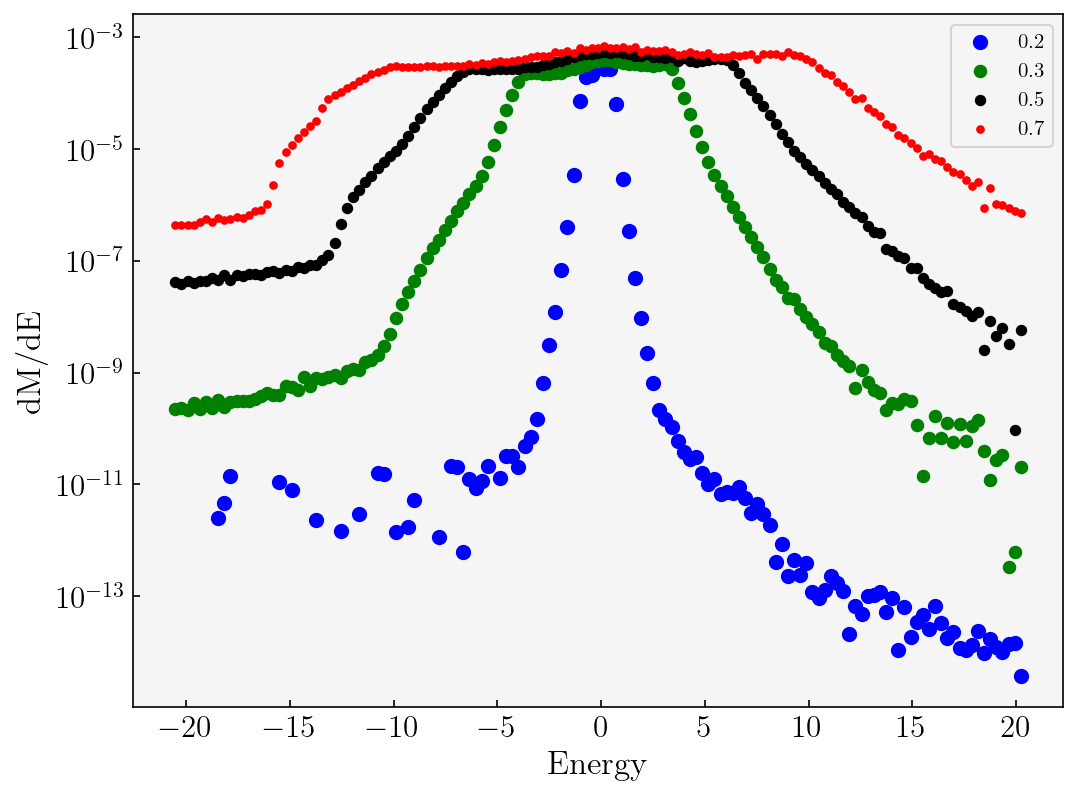

In [114]:
# plot the mass distribution with respect to the energy
plt.figure()
plt.scatter(bins[:-1]/normalization, data2/np.diff(bins), c = 'b', s = 40, label = '0.2')
plt.scatter(bins[:-1]/normalization, data3/np.diff(bins), c = 'green', s = 30, label = '0.3')
plt.scatter(bins[:-1]/normalization, data5/np.diff(bins), c = 'k', s = 20, label = '0.5')
plt.scatter(bins[:-1]/normalization, data7/np.diff(bins), c = 'r', s = 10, label = '0.7')
plt.xlabel('Energy', fontsize = 16)
plt.ylabel('dM/dE', fontsize = 16)
plt.yscale('log')

plt.legend()
